# Convert SavedModel to ONNX and TF Lite

In [1]:
from tensorflow.keras.models import load_model
import tensorflow as tf

In [2]:
import tensorflow_addons

In [3]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from itertools import product
from pathlib import Path
from loguru import logger
import cv2
from datetime import datetime
from skimage.measure import label, regionprops

In [4]:
!pwd

/workspaces/template_segmentation/src/tuto_saving


## Loading tf SavedModel

In [5]:
from src.metrics.mean_iou import UpdatedMeanIoU
from src.optimizers.cg_adam import GCAdam
from src.losses.focal_loss import SparseCategoricalFocalLoss
model = load_model("MobileViT-S_FPN_2021-10-13_18-18-27", custom_objects={"UpdatedMeanIoU": UpdatedMeanIoU, "GCAdam":GCAdam, "SparseCategoricalFocalLoss":SparseCategoricalFocalLoss})

In [6]:
model.summary()

Model: "FPN"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv_input (Conv2D)             (None, 128, 128, 16) 432         input_1[0][0]                    
__________________________________________________________________________________________________
tf.nn.silu (TFOpLambda)         (None, 128, 128, 16) 0           conv_input[0][0]                 
__________________________________________________________________________________________________
ivrb0 (InvertedResidualBottlene (None, 128, 128, 16) 3200        tf.nn.silu[0][0]                 
________________________________________________________________________________________________

## Converting to tflite

In [17]:
# Convert the model
converter = tf.lite.TFLiteConverter.from_saved_model("MobileViT-XXS_FPN_2021-10-13_17-37-15") # path to the SavedModel directory

converter.target_spec.supported_ops = [
  tf.lite.OpsSet.TFLITE_BUILTINS, # enable TensorFlow Lite ops.
  tf.lite.OpsSet.SELECT_TF_OPS # enable TensorFlow ops.
]

tflite_model = converter.convert()
# Save the model.
with open('MobileViT-XXS_FPN_2021-10-13_17-37-15.tflite', 'wb') as f:
    f.write(tflite_model)

## Converting to ONNX from tflite

In [9]:
!pip install -q tf2onnx

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 430 kB 8.5 MB/s eta 0:00:01
     |████████████████████████████████| 12.3 MB 29.7 MB/s eta 0:00:01
You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.


In [10]:
!python -m tf2onnx.convert --opset 13 --tflite model2.tflite --output test2.onnx

2021-10-13 18:00:07.170133: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
/usr/lib/python3.8/runpy.py:127: RuntimeWarning: 'tf2onnx.convert' found in sys.modules after import of package 'tf2onnx', but prior to execution of 'tf2onnx.convert'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
2021-10-13 18:00:07.974150: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2021-10-13 18:00:07.995578: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1034] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-13 18:00:07.995769: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1734] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 3090 computeCapability: 8.6
coreClock: 1.86GHz coreCount: 82 deviceMemorySize: 23.68GiB

## Converting to ONNX from SavedModel

In [12]:
!pip install -q onnxruntime

You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.


In [13]:
import tensorflow as tf
import tf2onnx
import onnxruntime as rt

spec = (tf.TensorSpec((None, 256, 256, 3), tf.float32, name="input"),)
output_path = "MobileViT-XXS_FPN_2021-10-13_17-37-15" + ".onnx"

model_proto, _ = tf2onnx.convert.from_keras(model, input_signature=spec, opset=13, output_path=output_path)
output_names = [n.name for n in model_proto.graph.output]

Instructions for updating:
Use `tf.compat.v1.graph_util.extract_sub_graph`


Instructions for updating:
Use `tf.compat.v1.graph_util.extract_sub_graph`


## Setting up pre & post-processing

In [7]:
def crop(image_path: Path, stride: int):

        cropped_images = []
        
        image_path = Path(image_path)
        
        image = Image.open(image_path).resize((1024, 1024))
        print(f"{image.size}")
        width, height = image.size

        grid = list(
            product(
                range(0, height - height % stride, stride),
                range(0, width - width % stride, stride),
            )
        )
        for idy, idx in grid:
            box = (idx, idy, idx + stride, idy + stride)

            cropped_image = image.crop(box)
            cropped_image= np.asarray(cropped_image, dtype="float32")/255
       
            cropped_images.append(cropped_image)
            
        logger.info("Done.")
        
        return np.array(cropped_images)


In [8]:
#image_path = "/media/vorph/datas/ecco/segmentation/datas/raw_datas/ML/images/frame_1619705157.915676.jpg"
#image_path = "/media/vorph/datas/ecco/segmentation/datas/raw_datas/ML/images/beinheim_batch_v2/brisures.jpeg"
#image_path = "/media/vorph/datas/ecco/segmentation/datas/raw_datas/ML/images/beinheim_batch_v2/cor2.jpeg"
image_path = "/media/vorph/datas/template_segmentation/datas/raw_datas/ML/images/beinheim_batch_v2/0148B.jpg"
#image_path = "/media/vorph/datas/ecco/segmentation/datas/raw_datas/ML/images/beinheim_batch_v2/m200_31981.jpeg"

In [9]:
image_path = Path(image_path)
        
image = Image.open(image_path).resize((1024, 1024))
print(f"{image.size}")
width, height = image.size

full_image= np.asarray(image, dtype="float32")/255


(1024, 1024)


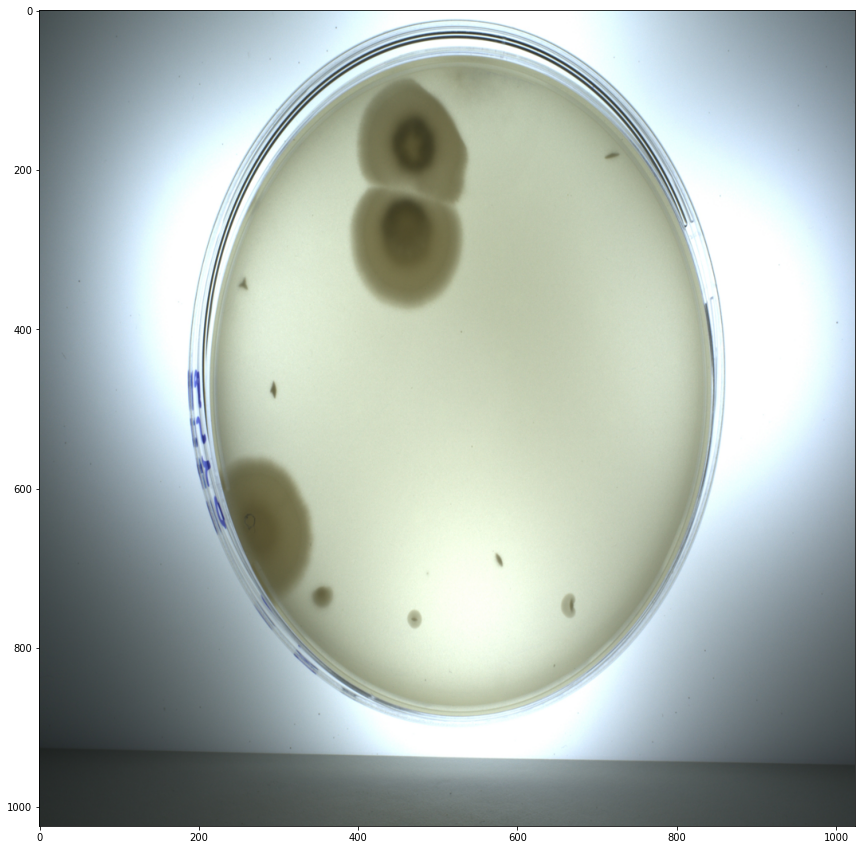

In [10]:
plt.figure(figsize=(15,15))
plt.imshow(full_image)

In [11]:
cropped = crop(image_path, 256)
cropped.shape

2021-10-13 20:11:40.363 | INFO     | __main__:crop:25 - Done.


(1024, 1024)


(16, 256, 256, 3)

## TF SavedModel prediction

In [12]:
preds = model.predict(cropped)

In [13]:
preds.shape

(16, 256, 256, 4)

In [14]:
predicted_masks = np.argmax(preds, axis=-1)
probabilities = np.max(preds, axis=-1)

In [15]:
mask = predicted_masks.reshape((4,4,256,256)).transpose(0,2,1,3).reshape((4*256,4*256))
probabilities = probabilities.reshape((4,4,256,256)).transpose(0,2,1,3).reshape((4*256,4*256))

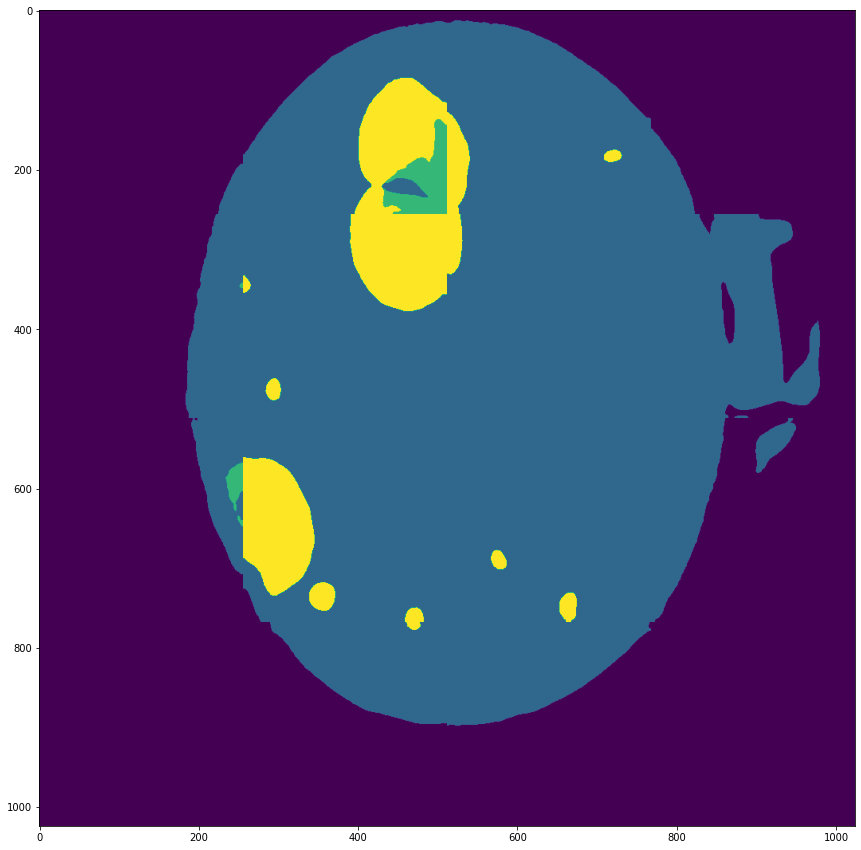

In [16]:
plt.figure(figsize=(15,15))
plt.imshow(mask)
plt.savefig("mask_tf.jpeg") 

## ONNX Runtime prediction

In [22]:
import onnxruntime as rt

model = "MobileViT-XXS_FPN_2021-10-13_17-37-15.onnx"

providers = ['CPUExecutionProvider']
m = rt.InferenceSession(model, providers=providers)
onnx_pred = m.run(['activation'], {"input": cropped})

In [23]:
onnx_pred[0].shape

(16, 256, 256, 4)

In [24]:
predicted_masks = np.argmax(onnx_pred, axis=-1)
probabilities = np.max(onnx_pred, axis=-1)

In [25]:
mask = predicted_masks.reshape((4,4,256,256)).transpose(0,2,1,3).reshape((4*256,4*256))
probabilities = probabilities.reshape((4,4,256,256)).transpose(0,2,1,3).reshape((4*256,4*256))

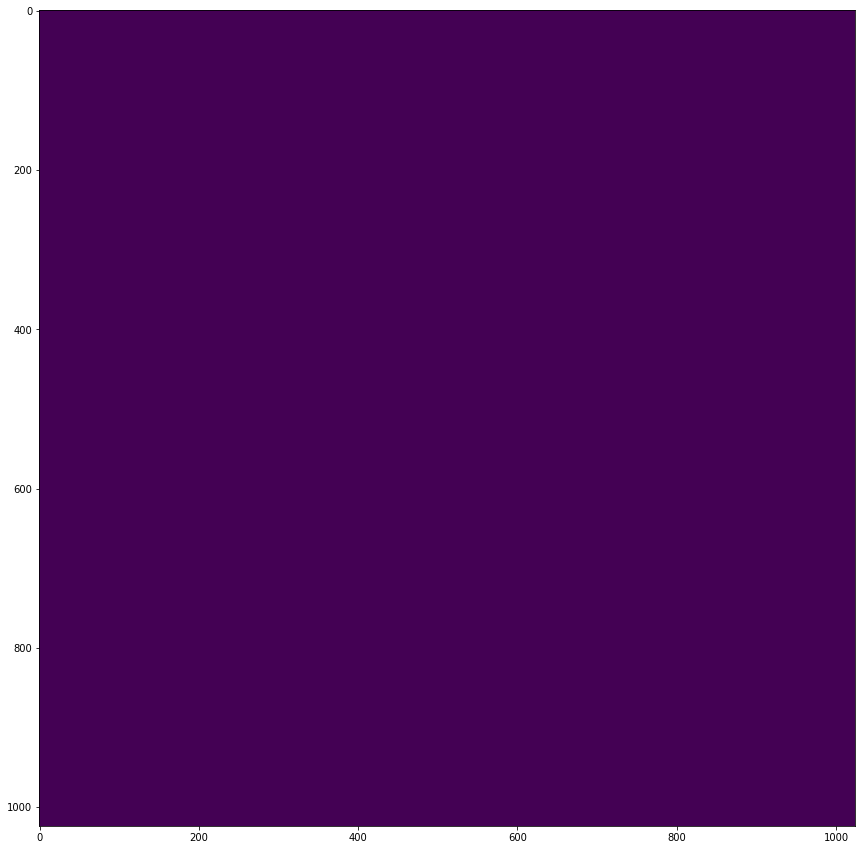

In [26]:
plt.figure(figsize=(15,15))
plt.imshow(mask)
plt.savefig("mask.jpeg") 

## Misc

In [129]:
mask = mask.astype(np.float64) / 3 # normalize the data to 0 - 1
mask = 255 * mask # Now scale by 255
mask = mask.astype(np.uint8)

In [130]:
255/3

85.0

In [131]:
255*2/3

170.0

In [132]:
def compute_segmentation_score(probabilities, labeled_mask, num_segment):
    segment = labeled_mask==num_segment
    scores_segment = probabilities*segment
    area_segment = np.sum(scores_segment > 0)
    mean_score_segment = np.sum(scores_segment)/area_segment
      
    return mean_score_segment
        
        

2021-08-12 20:14:40.076 | INFO     | __main__:<module>:23 - Found 9 levures
2021-08-12 20:14:40.084 | INFO     | __main__:<module>:33 - Found 1 moisissures


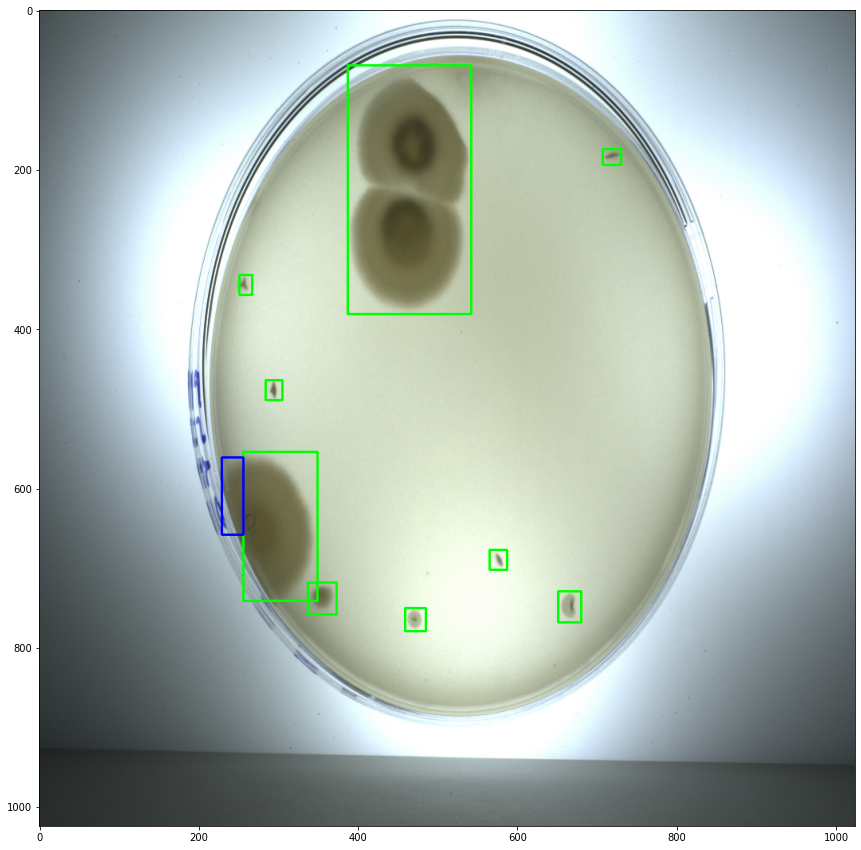

In [133]:
# draw detection results in resize image
img = cv2.imread(str(image_path))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img,(1024, 1024),interpolation=cv2.INTER_LINEAR,    )


_, threshold_levure = cv2.threshold(mask, 180, 255, cv2.THRESH_BINARY)
_, threshold2 = cv2.threshold(mask, 160, 255, cv2.THRESH_BINARY)
threshold_moisissure = threshold2 - threshold_levure
probabilities

true_levures = 0
true_moisissures = 0

labeled_levure, num_levure = label(threshold_levure, return_num=True) 
props_levure = regionprops(labeled_levure)

for prop, idx_segment in zip(props_levure, range(num_levure)):
    mean_score = compute_segmentation_score(probabilities, labeled_levure, idx_segment+1)
    if mean_score > 0.50:
        true_levures +=1
        img = cv2.rectangle(img, (prop.bbox[1], prop.bbox[0]), (prop.bbox[3], prop.bbox[2]), (0, 255, 0), 2)
logger.info(f"Found {true_levures} levures")
        
labeled_moisissure, num_moisissure = label(threshold_moisissure, return_num=True) 
props_moisissure = regionprops(labeled_moisissure)

for prop, idx_segment in zip(props_moisissure, range(num_moisissure)):
    mean_score = compute_segmentation_score(probabilities, labeled_moisissure, idx_segment+1)
    if mean_score > 0.50:
        true_moisissures +=1
        img = cv2.rectangle(img, (prop.bbox[1], prop.bbox[0]), (prop.bbox[3], prop.bbox[2]), (0, 0, 255), 2)
logger.info(f"Found {true_moisissures} moisissures")

plt.figure(figsize=(15,15))
plt.imshow(img)
plt.savefig("detection.jpeg") 